In [1]:
from __future__ import print_function
import matplotlib.image as imgplt
import matplotlib.pyplot as plt
import time
import os
import numpy as np
from IPython.display import display,Image
from scipy import misc
import cntk as C


np.random.seed(0)
C.cntk_py.set_fixed_random_seed(1)
C.cntk_py.force_deterministic_algorithms()
input_dim_model=(1,28,28)
num_labels=10
input_dim=28*28

def create_reader(path,istraining):
    deserializer=C.io.CTFDeserializer(path,C.io.StreamDefs(labels=C.io.StreamDef(field="labels",shape=num_labels,is_sparse=False),
                                                      features=C.io.StreamDef(field="features",shape=input_dim,is_sparse=False)))
    return C.io.MinibatchSource(deserializer,randomize=istraining,max_sweeps=C.io.INFINITELY_REPEAT if istraining else 1)

x=C.input_variable(input_dim_model)
y=C.input_variable(num_labels)




In [2]:
data_found=False # A flag to indicate if train/test data found in local cache
for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                 os.path.join("data", "MNIST")]:
    
    train_file=os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    test_file=os.path.join(data_dir, "Test-28x28_cntk_text.txt")
    
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found=True
        break
        
if not data_found:
    raise ValueError("Please generate the data by completing Lab1_MNIST_DataLoader")
    
print("Data directory is {0}".format(data_dir))

Data directory is data/MNIST


In [3]:
def create_model(features):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
            h = features
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=8, 
                                       strides=(2,2), 
                                       pad=True, name='first_conv')(h)
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=16, 
                                       strides=(2,2), 
                                       pad=True, name='second_conv')(h)
            r = C.layers.Dense(num_labels, activation=None, name='classify')(h)
            return r

In [4]:
         
z=create_model(x/255)

def create_criterion_function(model, labels):
    loss = C.cross_entropy_with_softmax(model, labels)
    errs = C.classification_error(model, labels)
    return loss,errs


In [5]:
# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error

In [6]:
def train_test(train_reader,test_reader,model_func):
    model=model_func(x/255)
    loss,label_error=create_criterion_function(model,y)
    lr_schedule=C.learning_rate_schedule(0.2,C.UnitType.minibatch)
    learner=C.sgd(z.parameters,lr_schedule)
    trainer=C.Trainer(z,(loss,label_error),[learner])
    
    minibatch_size = 64
    num_samples_per_sweep = 60000
    num_sweeps_to_train_with=10
    num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size
    input_map={
        y  : train_reader.streams.labels,
        x  : train_reader.streams.features
    } 
    plot_data={"batchsize":[],"loss":[],"error":[]}
    training_progress_output_freq=500
    start=time.time()
    for i in range (int(num_minibatches_to_train)):
        loss="NA"
        error="NA"
        data=train_reader.next_minibatch(minibatch_size,input_map=input_map)
        trainer.train_minibatch(data)
        batchsize,loss,eval_error=print_training_progress(trainer,i,training_progress_output_freq,verbose=1)
        if not (loss == "NA" or error =="NA"):
            
            plot_data["batchsize"].append(batchsize)
            plot_data["loss"].append(loss)
            plot_data["error"].append(error)
    print("Training took {:.1f} s".format(time.time()-start))
 

    #    plot_data["avg_loss"]=moving_average(plot_data["loss"])
#     plot_data["avg_error"]=moving_average(plot_data["error"])
#     plt.figure(1)
#     plt.subplot(2,1,1)
#     plt.plot(plot_data["batchsize"],plot_data["avg_loss"],"b--")
#     plt.xlabel("batchsize")
#     plt.ylabel("loss")
#     plt.show()
#     plt.subplot(2,1,2)
#     plt.plot(plot_data["batchsize"],plot_data["avg_error"],"r--")
#     plt.xlabel("batchsize")
#     plt.ylabel("error")
#     plt.show()

        
    test_input_map = {
        y  : test_reader.streams.labels,
        x  : test_reader.streams.features
        }

   
    test_minibatch_size = 512
    num_samples = 10000
    num_minibatches_to_test = num_samples // test_minibatch_size

    test_result = 0.0   

    for i in range(num_minibatches_to_test):
        data = test_reader.next_minibatch(test_minibatch_size, input_map=test_input_map)
        test_result+= trainer.test_minibatch(data)
        

    # Average of evaluation errors of all test minibatches
    print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))
    


In [7]:
def do_train_test():
    global z
    z = create_model(x)
    reader_train = create_reader(train_file, True)
    reader_test = create_reader(test_file, False)
    train_test(reader_train, reader_test, z)
    
do_train_test()

Minibatch: 0, Loss: 2.3062, Error: 92.19%
Minibatch: 500, Loss: 0.1375, Error: 1.56%
Minibatch: 1000, Loss: 0.0861, Error: 3.12%
Minibatch: 1500, Loss: 0.0680, Error: 3.12%
Minibatch: 2000, Loss: 0.0268, Error: 0.00%
Minibatch: 2500, Loss: 0.0136, Error: 0.00%
Minibatch: 3000, Loss: 0.0298, Error: 1.56%
Minibatch: 3500, Loss: 0.1896, Error: 7.81%
Minibatch: 4000, Loss: 0.0080, Error: 0.00%
Minibatch: 4500, Loss: 0.0551, Error: 3.12%
Minibatch: 5000, Loss: 0.0121, Error: 0.00%
Minibatch: 5500, Loss: 0.0330, Error: 1.56%
Minibatch: 6000, Loss: 0.0059, Error: 0.00%
Minibatch: 6500, Loss: 0.0208, Error: 0.00%
Minibatch: 7000, Loss: 0.0902, Error: 3.12%
Minibatch: 7500, Loss: 0.0088, Error: 0.00%
Minibatch: 8000, Loss: 0.0204, Error: 1.56%
Minibatch: 8500, Loss: 0.0118, Error: 0.00%
Minibatch: 9000, Loss: 0.0312, Error: 1.56%
Training took 162.8 s
Average test error: 1.39%


In [8]:
out=C.softmax(z)
reader_eval = create_reader(test_file, False)

eval_minibatch_size = 25
eval_input_map ={x: reader_eval.streams.features,
                 y: reader_eval.streams.labels} 

data = reader_eval.next_minibatch(eval_minibatch_size, input_map = eval_input_map)

img_label = data[y].asarray()

img_data = data[x].asarray()
img_data=np.reshape(img_data,(eval_minibatch_size,1,28,28))
predicted_label_prob = [out.eval(img_data[i]) for i in range(len(img_data))]


pred=[np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
actual_label=[np.argmax(img_label[i]) for i in range(len(img_label))]


print(pred[:25])
print(actual_label)

# i=12
# plt.imshow(np.reshape(img_data[12],(28,28)),cmap="gray_r")
# print(pred[i])
# plt.show()


[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4]
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4]


2


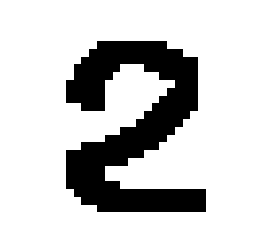

In [9]:
path=os.path.join("MysteryNumberD.png")
image=misc.imread(path,flatten=0)
image=image.reshape(1,28,28)
ans=out.eval(image.astype(np.float32))
print(np.argmax(ans))
plt.axis("off")

plt.imshow(image.reshape(28,28),cmap='gray_r')
plt.show()